<a href="https://colab.research.google.com/github/msadeghi322/DeepLearning/blob/main/NMA_Hyperparameters_W1D2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameters
In order to train a network, or even build a network model, there are a lot of decisions that need to be made beyond picking a network and training it. Decisions such as the learning rate parameter, the initialization values (w0), network architecture, and so on. To get a feel how such parameters would affect modeling, we take a very simple NN structure, with on input layer, one midle layer, and one output layer, that is a 1D network:


---
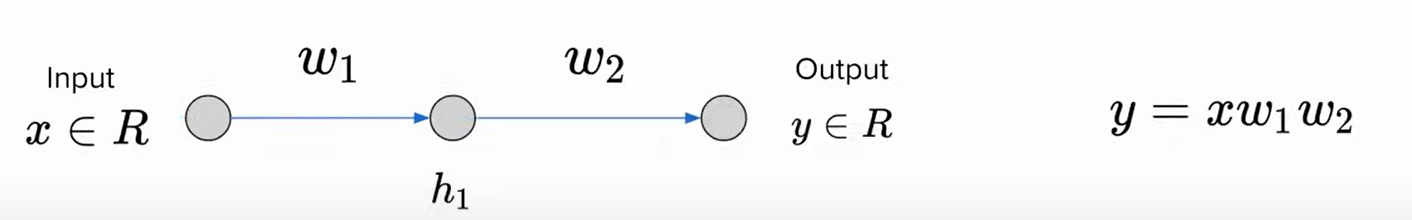


We pick a MSE loss: `L(w1,w2) = 1/P * [sum( (y-yp)**2 )]` \\


In [49]:
# @title Imports
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [50]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

from ipywidgets import interact, IntSlider, FloatSlider, fixed
from ipywidgets import HBox, interactive_output, ToggleButton, Layout
from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [51]:
# @title Plotting functions

def plot_x_y_(x_t_, y_t_, x_ev_, y_ev_, loss_log_, weight_log_):
  """
  Plot train data and test results

  Args:
  x_t_: np.ndarray
    Training dataset
  y_t_: np.ndarray
    Ground truth corresponding to training dataset
  x_ev_: np.ndarray
    Evaluation set
  y_ev_: np.ndarray
    ShallowNarrowNet predictions
  loss_log_: list
    Training loss records
  weight_log_: list
    Training weight records (evolution of weights)

  Returns:
    Nothing
  """
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 3, 1)
  plt.scatter(x_t_, y_t_, c='r', label='training data')
  plt.plot(x_ev_, y_ev_, c='b', label='test results', linewidth=2)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.subplot(1, 3, 2)
  plt.plot(loss_log_, c='r')
  plt.xlabel('epochs')
  plt.ylabel('mean squared error')
  plt.subplot(1, 3, 3)
  plt.plot(weight_log_)
  plt.xlabel('epochs')
  plt.ylabel('weights')
  plt.show()


def plot_vector_field(what, init_weights=None):
  """
  Helper function to plot vector fields

  Args:
    what: string
      If "all", plot vectors, trajectories and loss function
      If "vectors", plot vectors
      If "trajectory", plot trajectories
      If "loss", plot loss function

  Returns:
    Nothing
  """
  n_epochs=40
  lr=0.15
  x_pos = np.linspace(2.0, 0.5, 100, endpoint=True)
  y_pos = 1. / x_pos
  xx, yy = np.mgrid[-1.9:2.0:0.2, -1.9:2.0:0.2]
  zz = np.empty_like(xx)
  x, y = xx[:, 0], yy[0]

  x_temp, y_temp = gen_samples(10, 1.0, 0.0)

  cmap = matplotlib.cm.plasma
  plt.figure(figsize=(8, 7))
  ax = plt.gca()

  if what == 'all' or what == 'vectors':
    for i, a in enumerate(x):
      for j, b in enumerate(y):
        temp_model = ShallowNarrowLNN([a, b])
        da, db = temp_model.dloss_dw(x_temp, y_temp)
        zz[i, j] = temp_model.loss(temp_model.forward(x_temp), y_temp)
        scale = min(40 * np.sqrt(da**2 + db**2), 50)
        ax.quiver(a, b, - da, - db, scale=scale, color=cmap(np.sqrt(da**2 + db**2)))

  if what == 'all' or what == 'trajectory':
    if init_weights is None:
      for init_weights in [[0.5, -0.5], [0.55, -0.45], [-1.8, 1.7]]:
        temp_model = ShallowNarrowLNN(init_weights)
        _, temp_records = temp_model.train(x_temp, y_temp, lr, n_epochs)
        ax.scatter(temp_records[:, 0], temp_records[:, 1],
                    c=np.arange(len(temp_records)), cmap='Greys')
        ax.scatter(temp_records[0, 0], temp_records[0, 1], c='blue', zorder=9)
        ax.scatter(temp_records[-1, 0], temp_records[-1, 1], c='red', marker='X', s=100, zorder=9)
    else:
      temp_model = ShallowNarrowLNN(init_weights)
      _, temp_records = temp_model.train(x_temp, y_temp, lr, n_epochs)
      ax.scatter(temp_records[:, 0], temp_records[:, 1],
                  c=np.arange(len(temp_records)), cmap='Greys')
      ax.scatter(temp_records[0, 0], temp_records[0, 1], c='blue', zorder=9)
      ax.scatter(temp_records[-1, 0], temp_records[-1, 1], c='red', marker='X', s=100, zorder=9)

  if what == 'all' or what == 'loss':
    contplt = ax.contourf(x, y, np.log(zz+0.001), zorder=-1, cmap='coolwarm', levels=100)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(contplt, cax=cax)
    cbar.set_label('log (Loss)')

  ax.set_xlabel("$w_1$")
  ax.set_ylabel("$w_2$")
  ax.set_xlim(-1.9, 1.9)
  ax.set_ylim(-1.9, 1.9)

  plt.show()


def plot_loss_landscape():
  """
  Helper function to plot loss landscapes

  Args:
    None

  Returns:
    Nothing
  """
  x_temp, y_temp = gen_samples(10, 1.0, 0.0)

  xx, yy = np.mgrid[-1.9:2.0:0.2, -1.9:2.0:0.2]
  zz = np.empty_like(xx)
  x, y = xx[:, 0], yy[0]

  for i, a in enumerate(x):
    for j, b in enumerate(y):
      temp_model = ShallowNarrowLNN([a, b])
      zz[i, j] = temp_model.loss(temp_model.forward(x_temp), y_temp)

  temp_model = ShallowNarrowLNN([-1.8, 1.7])
  loss_rec_1, w_rec_1 = temp_model.train(x_temp, y_temp, 0.02, 240)

  temp_model = ShallowNarrowLNN([1.5, -1.5])
  loss_rec_2, w_rec_2 = temp_model.train(x_temp, y_temp, 0.02, 240)

  plt.figure(figsize=(12, 8))
  ax = plt.subplot(1, 1, 1, projection='3d')
  ax.plot_surface(xx, yy, np.log(zz+0.5), cmap='coolwarm', alpha=0.5)
  ax.scatter3D(w_rec_1[:, 0], w_rec_1[:, 1], np.log(loss_rec_1+0.5),
                c='k', s=50, zorder=9)
  ax.scatter3D(w_rec_2[:, 0], w_rec_2[:, 1], np.log(loss_rec_2+0.5),
                c='k', s=50, zorder=9)
  plt.axis("off")
  ax.view_init(45, 260)

  plt.show()


def depth_widget(depth):
  """
  Simulate parameter in widget
  exploring impact of depth on the training curve
  (loss evolution) of a deep but narrow neural network.

  Args:
    depth: int
      Specifies depth of network

  Returns:
    Nothing
  """
  if depth == 0:
    depth_lr_init_interplay(depth, 0.02, 0.9)
  else:
    depth_lr_init_interplay(depth, 0.01, 0.9)


def lr_widget(lr):
  """
  Simulate parameters in widget
  exploring impact of depth on the training curve
  (loss evolution) of a deep but narrow neural network.

  Args:
    lr: float
      Specifies learning rate within network

  Returns:
    Nothing
  """
  depth_lr_init_interplay(50, lr, 0.9)


def depth_lr_interplay(depth, lr):
  """
  Simulate parameters in widget
  exploring impact of depth on the training curve
  (loss evolution) of a deep but narrow neural network.

  Args:
    depth: int
      Specifies depth of network
    lr: float
      Specifies learning rate within network

  Returns:
    Nothing
  """
  depth_lr_init_interplay(depth, lr, 0.9)


def depth_lr_init_interplay(depth, lr, init_weights):
  """
  Simulate parameters in widget
  exploring impact of depth on the training curve
  (loss evolution) of a deep but narrow neural network.

  Args:
    depth: int
      Specifies depth of network
    lr: float
      Specifies learning rate within network
    init_weights: list
      Specifies initial weights of the network

  Returns:
    Nothing
  """
  n_epochs = 600

  x_train, y_train = gen_samples(100, 2.0, 0.1)
  model = DeepNarrowLNN(np.full((1, depth+1), init_weights))

  plt.figure(figsize=(10, 5))
  plt.plot(model.train(x_train, y_train, lr, n_epochs),
            linewidth=3.0, c='m')

  plt.title("Training a {}-layer LNN with"
  " $\eta=${} initialized with $w_i=${}".format(depth, lr, init_weights), pad=15)
  plt.yscale('log')
  plt.xlabel('epochs')
  plt.ylabel('Log mean squared error')
  plt.ylim(0.001, 1.0)
  plt.show()


def plot_init_effect():
  """
  Helper function to plot evolution of log mean
  squared error over epochs

  Args:
    None

  Returns:
    Nothing
  """
  depth = 15
  n_epochs = 250
  lr = 0.02

  x_train, y_train = gen_samples(100, 2.0, 0.1)

  plt.figure(figsize=(12, 6))
  for init_w in np.arange(0.7, 1.09, 0.05):
      model = DeepNarrowLNN(np.full((1, depth), init_w))
      plt.plot(model.train(x_train, y_train, lr, n_epochs),
              linewidth=3.0, label="initial weights {:.2f}".format(init_w))
  plt.title("Training a {}-layer narrow LNN with $\eta=${}".format(depth, lr), pad=15)
  plt.yscale('log')
  plt.xlabel('epochs')
  plt.ylabel('Log mean squared error')
  plt.legend(loc='lower left', ncol=4)
  plt.ylim(0.001, 1.0)
  plt.show()


class InterPlay:
  """
  Class specifying parameters for widget
  exploring relationship between the depth
  and optimal learning rate
  """

  def __init__(self):
    """
    Initialize parameters for InterPlay

    Args:
      None

    Returns:
      Nothing
    """
    self.lr = [None]
    self.depth = [None]
    self.success = [None]
    self.min_depth, self.max_depth = 5, 65
    self.depth_list = np.arange(10, 61, 10)
    self.i_depth = 0
    self.min_lr, self.max_lr = 0.001, 0.105
    self.n_epochs = 600
    self.x_train, self.y_train = gen_samples(100, 2.0, 0.1)
    self.converged = False
    self.button = None
    self.slider = None

  def train(self, lr, update=False, init_weights=0.9):
    """
    Train network associated with InterPlay

    Args:
      lr: float
        Specifies learning rate within network
      init_weights: float
        Specifies initial weights of the network [default: 0.9]
      update: boolean
        If true, show updates on widget

    Returns:
      Nothing
    """
    if update and self.converged and self.i_depth < len(self.depth_list):
      depth = self.depth_list[self.i_depth]
      self.plot(depth, lr)
      self.i_depth += 1
      self.lr.append(None)
      self.depth.append(None)
      self.success.append(None)
      self.converged = False
      self.slider.value = 0.005
      if self.i_depth < len(self.depth_list):
        self.button.value = False
        self.button.description = 'Explore!'
        self.button.disabled = True
        self.button.button_style = 'Danger'
      else:
        self.button.value = False
        self.button.button_style = ''
        self.button.disabled = True
        self.button.description = 'Done!'
      time.sleep(1.0)

    elif self.i_depth < len(self.depth_list):
      depth = self.depth_list[self.i_depth]
      # Additional assert: self.min_depth <= depth <= self.max_depth
      assert self.min_lr <= lr <= self.max_lr
      self.converged = False

      model = DeepNarrowLNN(np.full((1, depth), init_weights))
      self.losses = np.array(model.train(self.x_train, self.y_train, lr, self.n_epochs))
      if np.any(self.losses < 1e-2):
        success = np.argwhere(self.losses < 1e-2)[0][0]
        if np.all((self.losses[success:] < 1e-2)):
          self.converged = True
          self.success[-1] = success
          self.lr[-1] = lr
          self.depth[-1] = depth
          self.button.disabled = False
          self.button.button_style = 'Success'
          self.button.description = 'Register!'
        else:
          self.button.disabled = True
          self.button.button_style = 'Danger'
          self.button.description = 'Explore!'
      else:
        self.button.disabled = True
        self.button.button_style = 'Danger'
        self.button.description = 'Explore!'
      self.plot(depth, lr)

  def plot(self, depth, lr):
    """
    Plot following subplots:
    a. Log mean squared error vs Epochs
    b. Learning time vs Depth
    c. Optimal learning rate vs Depth

    Args:
      depth: int
        Specifies depth of network
      lr: float
        Specifies learning rate of network

    Returns:
      Nothing
    """
    fig = plt.figure(constrained_layout=False, figsize=(10, 8))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    ax1.plot(self.losses, linewidth=3.0, c='m')
    ax1.set_title("Training a {}-layer LNN with"
    " $\eta=${}".format(depth, lr), pad=15, fontsize=16)
    ax1.set_yscale('log')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('Log mean squared error')
    ax1.set_ylim(0.001, 1.0)

    ax2.set_xlim(self.min_depth, self.max_depth)
    ax2.set_ylim(-10, self.n_epochs)
    ax2.set_xlabel('Depth')
    ax2.set_ylabel('Learning time (Epochs)')
    ax2.set_title("Learning time vs depth", fontsize=14)
    ax2.scatter(np.array(self.depth), np.array(self.success), c='r')

    ax3.set_xlim(self.min_depth, self.max_depth)
    ax3.set_ylim(self.min_lr, self.max_lr)
    ax3.set_xlabel('Depth')
    ax3.set_ylabel('Optimal learning rate')
    ax3.set_title("Empirically optimal $\eta$ vs depth", fontsize=14)
    ax3.scatter(np.array(self.depth), np.array(self.lr), c='r')

    plt.show()

In [63]:
# @title Helper functions

def gen_samples(n, a, sigma):
  """
  Generates n samples with
  `y = z * x + noise(sigma)` linear relation.

  Args:
    n : int
      Number of datapoints within sample
    a : float
      Offset of x
    sigma : float
      Standard deviation of distribution

  Returns:
    x : np.array
      if sigma > 0, x = random values
      else, x = evenly spaced numbers over a specified interval.
    y : np.array
      y = z * x + noise(sigma)
  """
  assert n > 0
  assert sigma >= 0

  if sigma > 0:
    x = np.random.rand(n)
    noise = np.random.normal(scale=sigma, size=(n))
    y = a * x + noise
  else:
    x = np.linspace(0.0, 1.0, n, endpoint=True)
    y = a * x
  return x, y


class ShallowNarrowLNN:
  """
  Shallow and narrow (one neuron per layer)
  linear neural network
  """

  def __init__(self, init_ws):
    """
    Initialize parameters of ShallowNarrowLNN

    Args:
      init_ws: initial weights as a list

    Returns:
      Nothing
    """
    assert isinstance(init_ws, list)
    assert len(init_ws) == 2
    self.w1 = init_ws[0]
    self.w2 = init_ws[1]

  def forward(self, x):
    """
    The forward pass through network y = x * w1 * w2

    Args:
      x: np.ndarray
        Input data

    Returns:
      y: np.ndarray
        y = x * w1 * w2
    """
    y = x * self.w1 * self.w2
    return y

  def loss(self, y_p, y_t):
    """
    Mean squared error (L2)
    with 1/2 for convenience

    Args:
      y_p: np.ndarray
        Network Predictions
      y_t: np.ndarray
        Targets

    Returns:
      mse: float
        Average mean squared error
    """
    assert y_p.shape == y_t.shape
    mse = ((y_t - y_p)**2).mean()
    return mse

  def dloss_dw(self, x, y_t):
    """
    Partial derivative of loss with respect to weights

    Args:
      x : np.array
        Input Dataset
      y_t : np.array
        Corresponding Ground Truth

    Returns:
      dloss_dw1: float
        -mean(2 * self.w2 * x * Error)
      dloss_dw2: float
        -mean(2 * self.w1 * x * Error)
    """
    assert x.shape == y_t.shape
    Error = y_t - self.w1 * self.w2 * x
    dloss_dw1 = - (2 * self.w2 * x * Error).mean()
    dloss_dw2 = - (2 * self.w1 * x * Error).mean()
    return dloss_dw1, dloss_dw2

  def train(self, x, y_t, eta, n_ep):
    """
    Gradient descent algorithm

    Args:
      x : np.array
        Input Dataset
      y_t : np.array
        Corrsponding target
      eta: float
        Learning rate
      n_ep : int
        Number of epochs

    Returns:
      loss_records: np.ndarray
        Log of loss per epoch
      weight_records: np.ndarray
        Log of weights per epoch
    """
    assert x.shape == y_t.shape

    loss_records = np.empty(n_ep)  # Pre allocation of loss records
    weight_records = np.empty((n_ep, 2))  # Pre allocation of weight records

    for i in range(n_ep):
      y_p = self.forward(x)
      loss_records[i] = self.loss(y_p, y_t)
      dloss_dw1, dloss_dw2 = self.dloss_dw(x, y_t)
      self.w1 -= eta * dloss_dw1
      self.w2 -= eta * dloss_dw2
      weight_records[i] = [self.w1, self.w2]

    return loss_records, weight_records


class DeepNarrowLNN:
  """
  Deep but thin (one neuron per layer)
  linear neural network
  """

  def __init__(self, init_ws):
    """
    Initialize parameters of DeepNarrowLNN

    Args:
      init_ws: np.ndarray
        Initial weights as a numpy array

    Returns:
      Nothing
    """
    self.n = init_ws.size
    self.W = init_ws.reshape(1, -1)

  def forward(self, x):
    """
    Forward pass of DeepNarrowLNN

    Args:
      x : np.array
        Input features

    Returns:
      y: np.array
        Product of weights over input features
    """
    y = np.prod(self.W) * x
    return y

  def loss(self, y_t, y_p):
    """
    Mean squared error (L2 loss)

    Args:
      y_t : np.array
        Targets
      y_p : np.array
        Network's predictions

    Returns:
      mse: float
        Mean squared error
    """
    assert y_p.shape == y_t.shape
    mse = ((y_t - y_p)**2 / 2).mean()
    return mse

  def dloss_dw(self, x, y_t, y_p):
    """
    Analytical gradient of weights

    Args:
      x : np.array
        Input features
      y_t : np.array
        Targets
      y_p : np.array
        Network Predictions

    Returns:
      dW: np.ndarray
        Analytical gradient of weights
    """
    E = y_t - y_p  # i.e., y_t - x * np.prod(self.W)
    Ex = np.multiply(x, E).mean()
    Wp = np.prod(self.W) / (self.W + 1e-9)
    dW = - Ex * Wp
    return dW

  def train(self, x, y_t, eta, n_epochs):
    """
    Training using gradient descent

    Args:
      x : np.array
        Input Features
      y_t : np.array
        Targets
      eta: float
        Learning rate
      n_epochs : int
        Number of epochs

    Returns:
      loss_records: np.ndarray
        Log of loss over epochs
    """
    loss_records = np.empty(n_epochs)
    loss_records[:] = np.nan
    for i in range(n_epochs):
      y_p = self.forward(x)
      loss_records[i] = self.loss(y_t, y_p).mean()
      dloss_dw = self.dloss_dw(x, y_t, y_p)
      if np.isnan(dloss_dw).any() or np.isinf(dloss_dw).any():
        return loss_records
      self.W -= eta * dloss_dw
    return loss_records

In [53]:
#@title Set random seed

#@markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [54]:
#@title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

### Bulding a simple NN

In [55]:

class my_network:

  def __init__(self,init_weight):

    assert isinstance(init_weight, (list, np.ndarray, tuple))
    assert len(init_weight)==2
    self.w1 = init_weight[0]
    self.w2 = init_weight[1]

  def forward(self, x):
    y = self.w1 * self.w2 * x
    return y


  def loss(self, y, y_true):
    assert y.shape == y_true.shape
    Loss = (y-y_true)**2
    return Loss.mean()



  def dloss_dw(self, x , y_true):

    assert x.shape == y_true.shape
    # gradient of loss function wrt w:
    # Loss = (prediction-y_true)**2
    y = self.forward(x)
    dL_dw1 = -2 * (y_true-y) * self.w2 * x
    dL_dw2 = -2 * (y_true-y) * self.w1 * x
    return dL_dw1.mean(), dL_dw2.mean()



  def train(self, x, y_true, lr, n_ep):
    assert x.shape == y_true.shape
    loss_record = np.zeros(n_ep)
    weightRec = np.zeros((n_ep,2))

    for i in range(n_ep):
      y = self.forward(x)
      loss_record[i] = self.loss(y, y_true)
      dLoss1, dLoss2 = self.dloss_dw(x , y_true)
      self.w1 -= lr * dLoss1
      self.w2 -= lr * dLoss2
      weightRec[i] = [self.w1 , self.w2]
    return loss_record , weightRec



Random seed 2021 has been set.


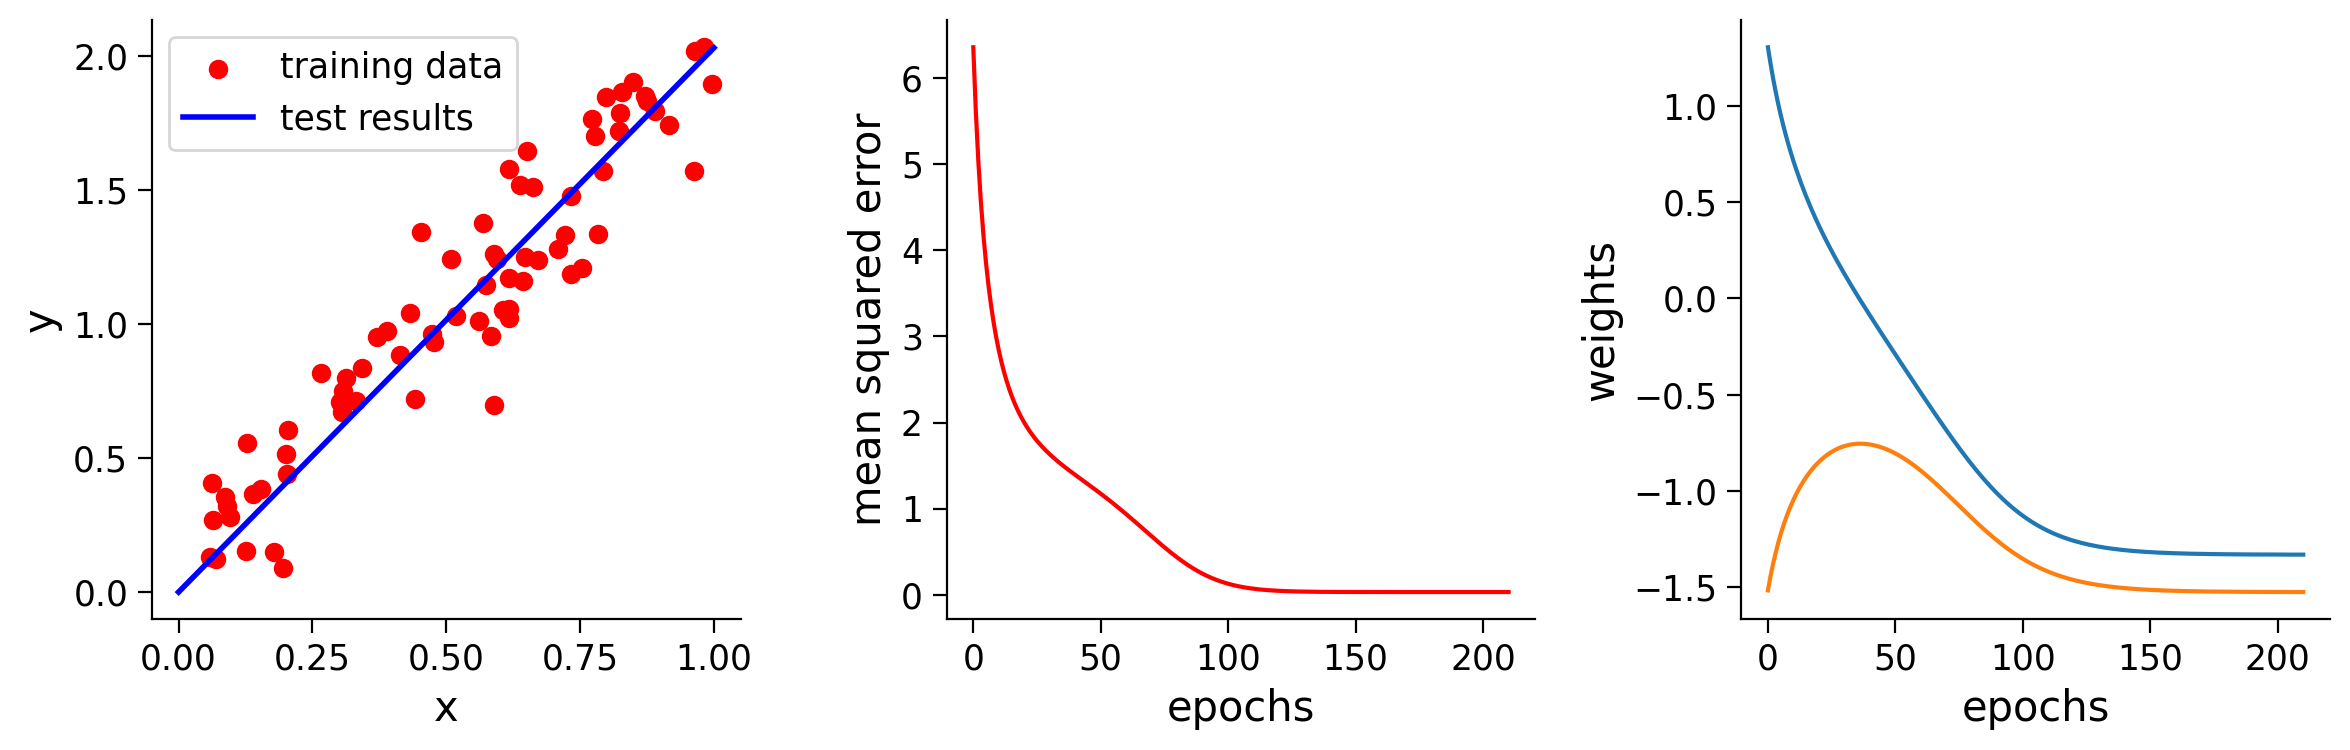

In [64]:
set_seed(2021)
n_ep = 211
lr = .02
W0 = [1.4, -1.6]
x_train, y_train = gen_samples(n=73, a=2.0, sigma=0.2)
x_eval = np.linspace(0.0, 1.0, 37, endpoint=True)

sn_model = my_network(W0)
loss_log, weight_log = sn_model.train(x_train, y_train, lr, n_ep)
y_eval = sn_model.forward(x_eval)
plot_x_y_(x_train, y_train, x_eval, y_eval, loss_log, weight_log)

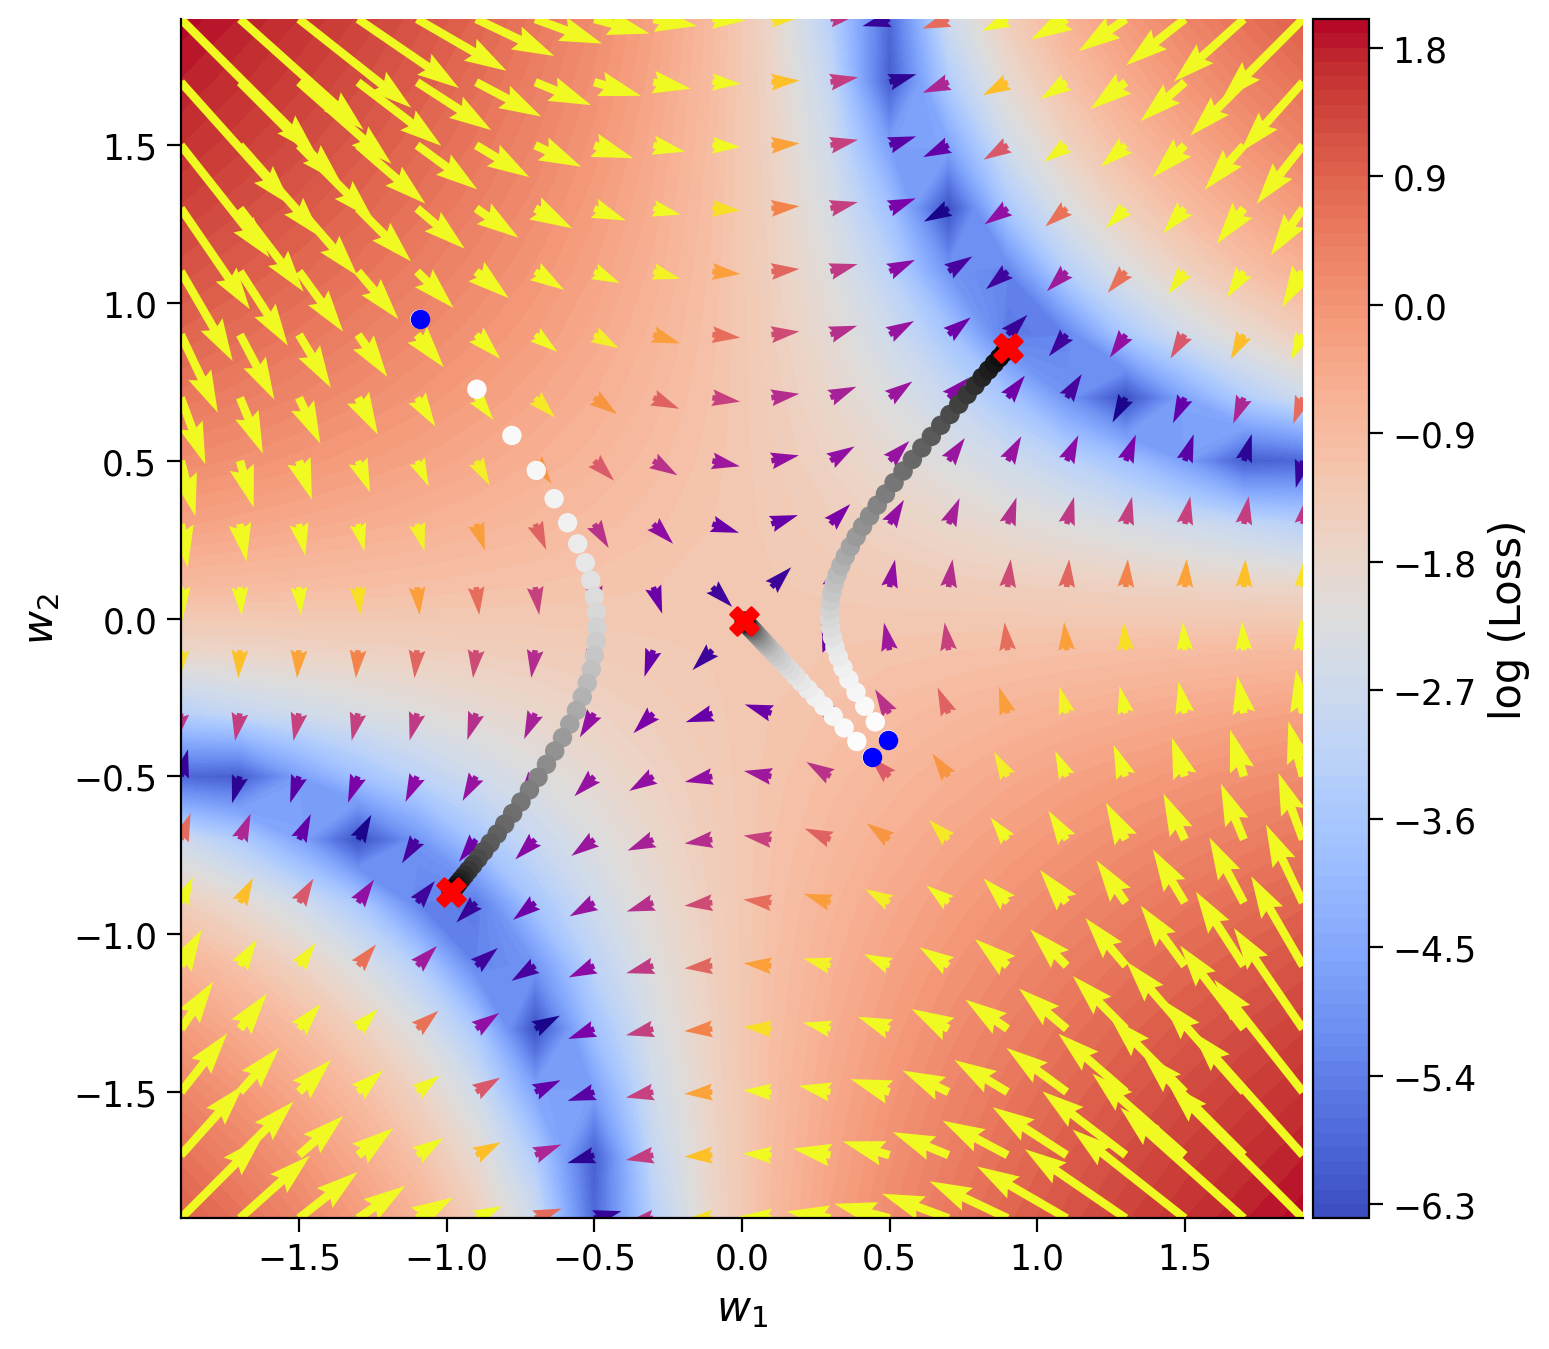

In [61]:
# @title Visualize loss landscape
plot_vector_field('all')
#plot_vector_field('vectors')  # For vector field
#plot_vector_field('trajectory')  # For training trajectory
#plot_vector_field('loss')  # For loss contour

In [28]:
# @title Effects of depth

_ = interact(depth_widget,
    depth = IntSlider(min=0, max=51,
                      step=5, value=0,
                      continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='depth', max=51, step=5), Output…

In [29]:
# @title Effects of learning rate

_ = interact(lr_widget,
    lr = FloatSlider(min=0.005, max=0.045, step=0.005, value=0.005,
                     continuous_update=False, readout_format='.3f',
                     description='eta'))

interactive(children=(FloatSlider(value=0.005, continuous_update=False, description='eta', max=0.045, min=0.00…

### Interaction of learning rate and depth
Important instruction The exercise starts with 10 hidden layers. Your task is to find the learning rate that delivers fast but robust convergence (learning). When you are confident about the learning rate, you can Register the optimal learning rate for the given depth. Once you press register, a deeper model is instantiated, so you can find the next optimal learning rate. The Register button turns green only when the training converges, but does not imply the fastest convergence.

In [31]:

intpl_obj = InterPlay()

intpl_obj.slider = FloatSlider(min=0.005, max=0.105, step=0.005, value=0.005,
                               layout=Layout(width='500px'),
                               continuous_update=False,
                               readout_format='.3f',
                               description='eta')

intpl_obj.button = ToggleButton(value=intpl_obj.converged, description='Register')

widgets_ui = HBox([intpl_obj.slider, intpl_obj.button])
widgets_out = interactive_output(intpl_obj.train,
                                 {'lr': intpl_obj.slider,
                                  'update': intpl_obj.button,
                                  'init_weights': fixed(0.9)})

display(widgets_ui, widgets_out)

Output()

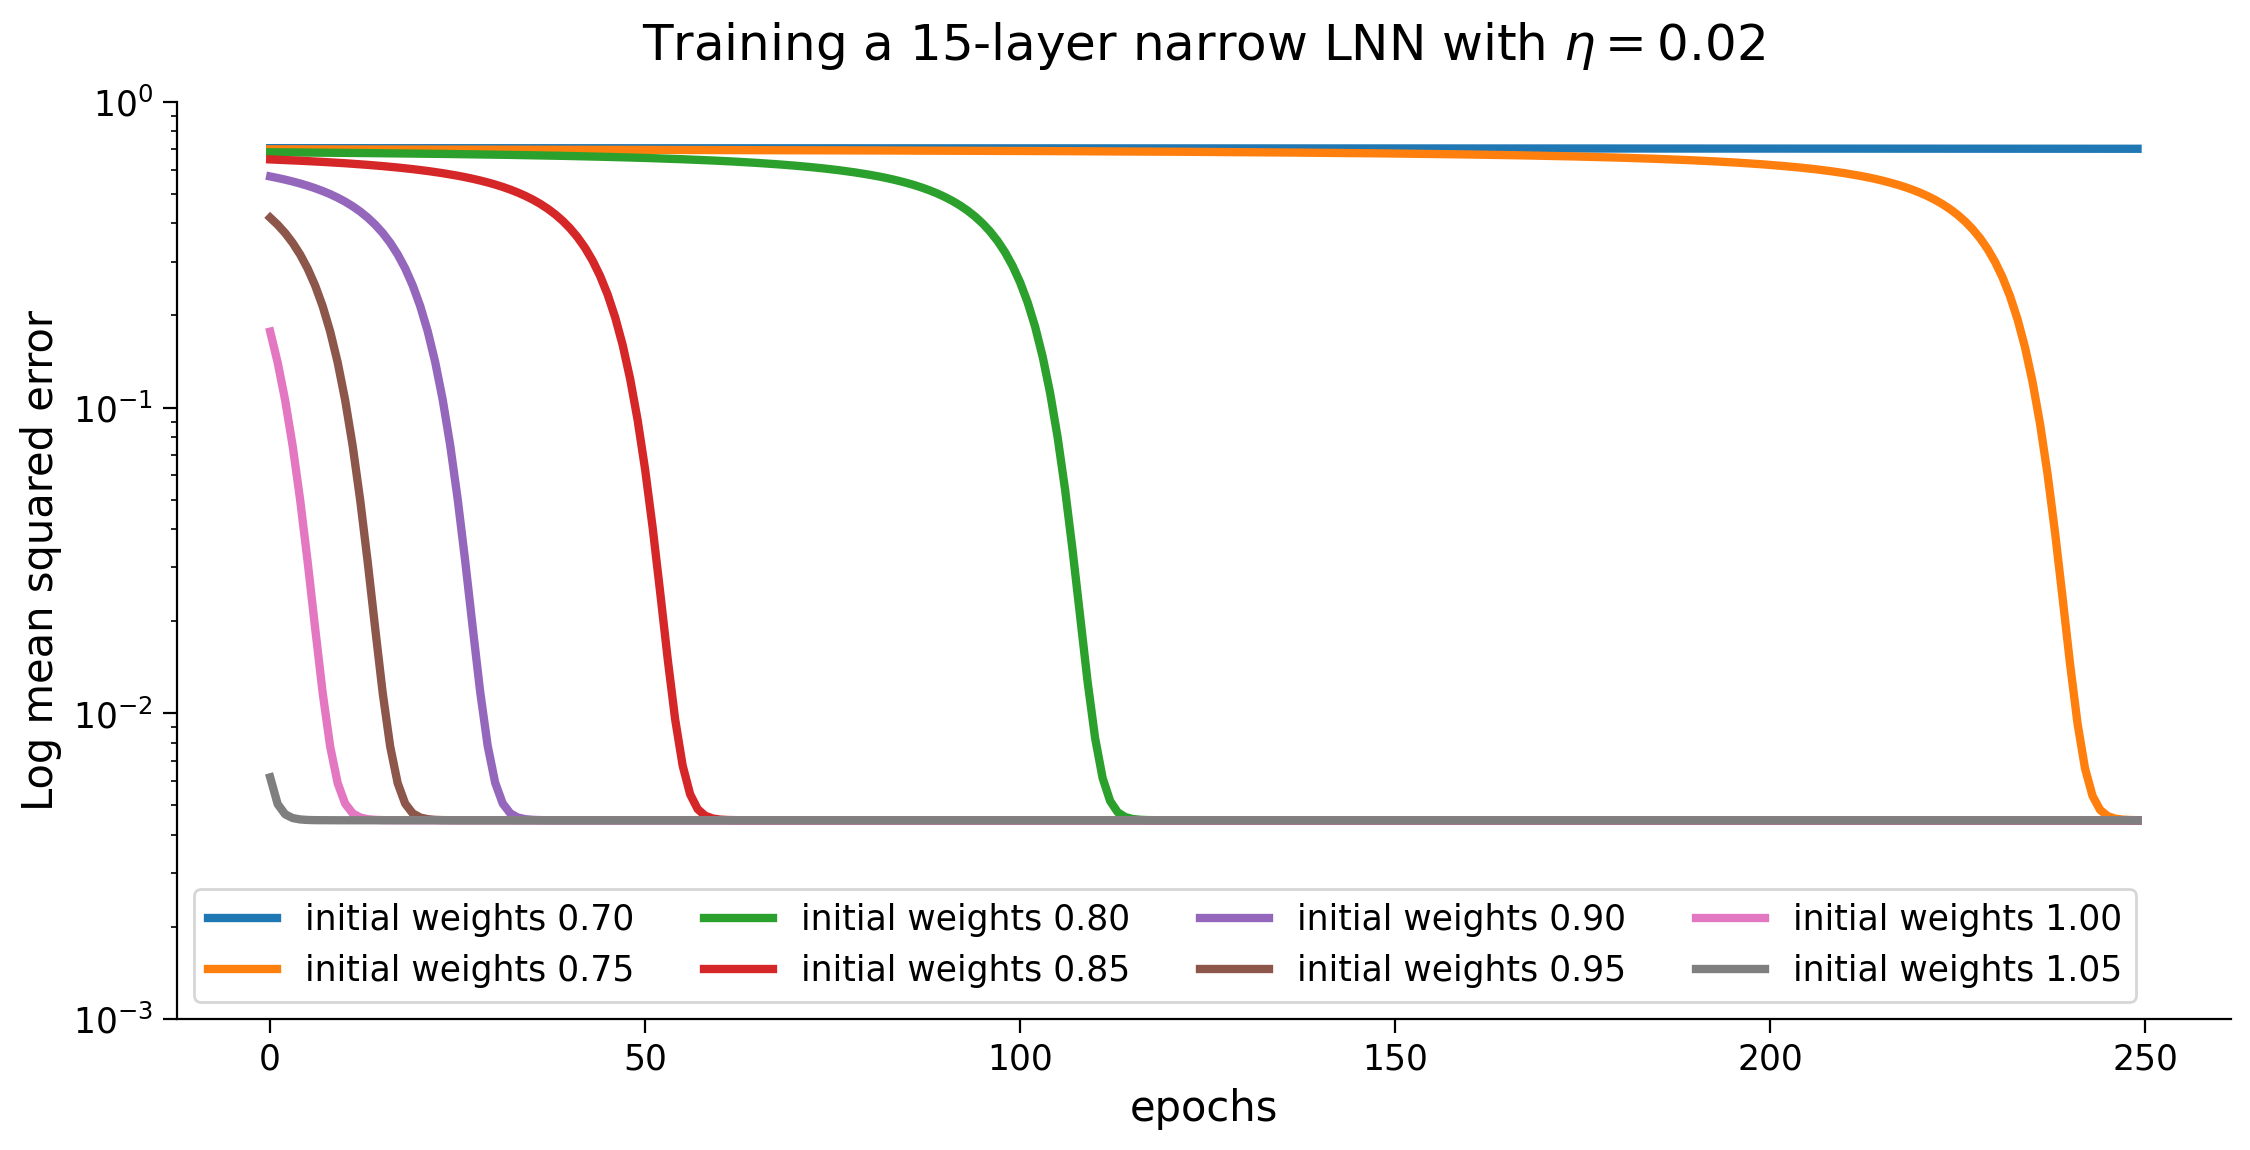

In [65]:
# @title Initialization effect

plot_init_effect()